In [1]:
import torch
from torch import nn
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import numpy as np
from torch import optim
from tqdm import tqdm
import math

torch.manual_seed(0)

## download CIFAR-10

In [2]:
batch_size = 64
train_data = CIFAR10(
        root="data",
        train=True,
        download=True,
        transform=ToTensor(),
    )
test_data = CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def validate(model, testloader, criterion, device):
    model.eval()
    print("Validation")
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1

            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100.0 * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [4]:
from torchvision.models import ResNet18_Weights

class ClassifierHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.classifier = nn.Linear(in_features=512, out_features=10, bias=True)
    
    def forward(self, x):
        return self.classifier(x)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

In [5]:
path = 'data/weights_1.pt'

model = resnet18().to(device)
model.fc = ClassifierHead().to(device)
model.load_state_dict(torch.load(path))
model.eval();

/tmp/ipykernel_445928/2698396606.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


In [6]:
validate(model, test_dataloader, criterion, device)

Validation


100%|██████████| 157/157 [00:01<00:00, 127.33it/s]


(1.1781141660205878, 82.37)

### Тестируем атаку

Попробуем провести атаку на нашу исходную модель $f(x) = \text{model}(x)$, а также на Randomized Smoothing Monte-Carlo Estimation $g(x) = \frac{1}{N} \sum \limits_{i = 1}^N f(x + \varepsilon_i)$

In [7]:
def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1,2,0)))

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]

In [8]:
from torchvision.transforms.v2 import GaussianNoise

class GHatDetermined(nn.Module):
    '''
    GHat model with fixed values epsilon[i], i = 1...N
    '''
    def __init__(self, model, sigma=0.1, n_samples=100):
        super().__init__()

        self.n_samples = n_samples
        self.noiser = GaussianNoise(mean=0, sigma=sigma)
        self.model = model.to(device)
        self.epsilons = [
            self.noiser(torch.zeros(3, 32, 32)).to(device)
            for _ in range(self.n_samples)
        ]
        self.softmax = nn.Softmax()

    def forward(self, x):
        probs = torch.zeros(1, 10).to(device)
        probs.requires_grad = True
        for i in range(self.n_samples):
            new_x = x + self.epsilons[i]
            probs = probs + self.softmax(self.model(new_x))
        probs /= self.n_samples
        return probs

class GHat:
    def __init__(self, model, sigma=0.1, n_samples=100):
        self.noiser = GaussianNoise(mean=0.0, sigma=sigma)
        self.n_samples = n_samples
        self.model = model.to(device)
        self.softmax = nn.Softmax()
    
    def forward(self, image):
        image = image.to(device)
        if len(image.shape) == 3:
            image = image.unsqueeze(dim=0)
        probs = torch.zeros(1, 10).to(device)
        for iteration in range(self.n_samples):
            probs += self.softmax(self.model(self.noiser(image)))
        probs /= self.n_samples
        return probs
    
    def __call__(self, image):
        return self.forward(image)

In [9]:
ghat = GHat(model, n_samples=100)

In [10]:
def random_attack(model, image, true_label, noiser=GaussianNoise(mean=0, sigma=0.05), n_tries=100):
    true_label = model(image.unsqueeze(dim=0).to(device)).argmax().item()
    for attempt in range(1, n_tries + 1):
        new_image = noiser(image)
        new_image = new_image.unsqueeze(dim=0).to(device)
        label = model(new_image).argmax().item()
        if label != true_label:
            new_image = new_image.squeeze(0).detach()
            return label, new_image, attempt

In [11]:
def fgsm_attack(model, image, true_label, epsilon=0.01):
    model.eval()
    
    if len(image.shape) == 3:
        image = image.unsqueeze(dim=0)
    image = image.to(device)
    image.requires_grad = True
    
    output = model(image)
    loss = criterion(model(image), torch.tensor([true_label]).to(device))
    model.zero_grad()
    loss.backward()
    
    image_grad = image.grad
    
    bad_image = image + epsilon * image_grad.sign()
    bad_image = torch.clamp(bad_image, 0, 1)

    label = model(bad_image).argmax().item()
    has_attack_worked = (label != true_label)
    
    bad_image = bad_image.squeeze(0).detach()
    
    return has_attack_worked, bad_image, label

In [12]:
def get_gradient_estimation(model, image, true_label, n_samples=10):
    model.eval()
    if len(image.shape) == 3:
        image = image.unsqueeze(dim=0)
    image = image.to(device)
    image.requires_grad = True
    loss_fn = nn.NLLLoss()

    for _ in range(n_samples):
        gdet = GHatDetermined(model)
        log_prob = torch.log(gdet(image))
        loss = loss_fn(log_prob, torch.tensor([true_label]).to(device))
        loss.backward()
        model.zero_grad()
    grad_estimation = image.grad / n_samples
    return grad_estimation

In [13]:
def gradient_estimation_attack(model, image, true_label, epsilon=0.04, n_samples=10):
    model.eval()

    image = image.to(device)
    gradient_estimation = get_gradient_estimation(model, image, true_label, n_samples).to(device)
    bad_image = image + epsilon * gradient_estimation.sign()
    bad_image = torch.clamp(bad_image, 0, 1)

    ghat = GHat(model)
    new_label = ghat(bad_image).argmax().item()
    if new_label != true_label:
        bad_image = bad_image.squeeze(0).detach()
        return True, bad_image, new_label
    return False, False, False

### Атакуем с Randomized Smoothing Monte-Carlo Estimation

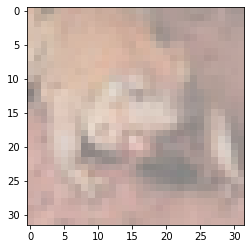

In [14]:
images_batch, labels_batch = next(iter(test_dataloader))
image = images_batch[5]
true_label = labels_batch[5].item()
imshow(image)

### Атакуем картинку с min $p_a - p_b$

/home/user17/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


min(p_a-p_b)=0.006442546844482422. p_a=0.50061, p_b=0.49417. class=bird


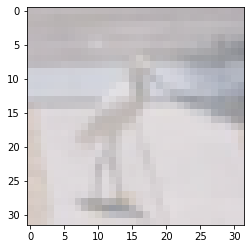

In [15]:
# ищем картинку с наим p_a-p_b
worked_attack_ratio = 0.0
done=False
min_gap = [100, (0,0), None, '']
for image_batch, label_batch in test_dataloader:
    image_batch = image_batch.to(device)
    label_batch = label_batch.to(device)

    for image, label in zip(image_batch, label_batch):
        p_sorted = (nn.Softmax()(model(image.unsqueeze(dim=0)))[0]).sort(descending=True)
        label_predicted = p_sorted.indices[0].item()
        if label_predicted == label:
            p_a = p_sorted.values[0].item()  # a_class = p_sorted.indices[0].item()
            p_b = p_sorted.values[1].item()
            min_gap = min(min_gap, [p_a-p_b, (p_a, p_b), image, label])
    
print(f'min(p_a-p_b)={min_gap[0]}. p_a={round(min_gap[1][0], 5)}, p_b={round(min_gap[1][1], 5)}. class={classes[min_gap[3].item()]}')
imshow(min_gap[2].cpu())


without attack:
real class: 'bird', predicted: 'bird', 'airplane'


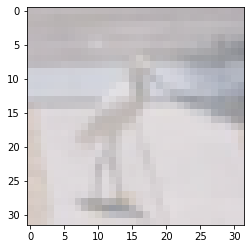

In [16]:
image = min_gap[2]
label = min_gap[3]
imshow(image.cpu())
print('without attack:')
print(f"real class: '{classes[min_gap[3].item()]}', predicted: '{classes[model(image.unsqueeze(dim=0)).argmax().item()]}', '{classes[(nn.Softmax()(model(image.unsqueeze(dim=0)))[0].sort(descending=True)).indices[1].item()]}'")

In [17]:
# начинаем атаковать
has_attack_worked = False
eps = 4 * 10**(-6)

for _ in range(10):
    cnt_success_attacks = 0

    
    has_attack_worked, bad_image, new_label = fgsm_attack(model, image, label, epsilon=eps)
        # if has_attack_worked and model(image.unsqueeze(dim=0)).argmax() == label:
        #     done=True
        #     print(f'Worked! Changed class from {classes[label.item()]} to {classes[new_label]}')
        #     imshow(image.cpu())
    eps /= 1.1
    if not has_attack_worked:
        print(f'p_gap={p_a - p_b}, p_gap/eps={min_gap[0] / eps}')
        break

p_gap=0.9999999418987926, p_gap/eps=2593.946529626848


### Посмотрим зависимость граничного $\epsilon$ от $p_a-b_b$ в этой атаке


In [18]:
eps_dependence = [[], [], [], []]  # [[p_gap, ...], [eps, ...], [certified_radius, ...], [l2_norm, ...]]

for image_batch, label_batch in test_dataloader:
    image_batch = image_batch.to(device)
    label_batch = label_batch.to(device)

    for image, label in zip(image_batch, label_batch):
        p_sorted = (nn.Softmax()(model(image.unsqueeze(dim=0)))[0]).sort(descending=True)
        label_predicted = p_sorted.indices[0].item()
        if label_predicted != label:
            continue
        p_a = p_sorted.values[0].item()  # a_class = p_sorted.indices[0].item()
        p_b = p_sorted.values[1].item()
        p_gap = p_a-p_b
        if p_a > 0.9:
            continue

        eps = 5
        is_success_attack = True
        while is_success_attack:         
            eps *= 0.9
            is_success_attack = False
           
            is_success_attack, bad_image, new_label = fgsm_attack(model, image, label, epsilon=eps)
            cnt_success_attacks += has_attack_worked.item()
        
        
        phi_inv = lambda x: torch.distributions.Normal(0, 1).icdf(torch.tensor(x))
        certified_radius = 0.1 / 2 * (phi_inv(p_a) - phi_inv(p_b)).item()

        l2_norm = (bad_image - image).norm()
        
        # print(f'p_a-p_b={round(p_gap, 5)}, p_a={round(p_a, 5)}, p_b={round(p_b, 5)}. eps={eps}. (p_a-p_b)/eps={p_gap / eps}') 
        eps_dependence[0].append(p_gap)
        eps_dependence[1].append(eps)
        eps_dependence[2].append(certified_radius)
        eps_dependence[3].append(l2_norm)

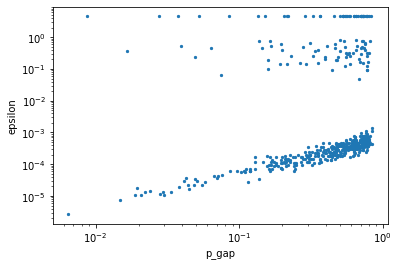

In [27]:
plt.scatter(eps_dependence[0], eps_dependence[1], s=5)
plt.xlabel('p_gap')
plt.ylabel('epsilon')
plt.xscale('log')
plt.yscale('log')
plt.savefig('graphics/epsilon vs p_gap.png', transparent=False, facecolor='white', dpi=1000)

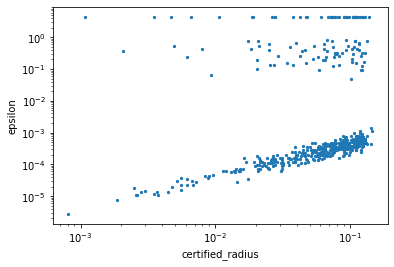

In [28]:
plt.scatter(eps_dependence[2], eps_dependence[1], s=5)
plt.xlabel('certified_radius')
plt.ylabel('epsilon')
plt.xscale('log')
plt.yscale('log')
plt.savefig('graphics/epsilon vs certified_radius.png', transparent=False, facecolor='white', dpi=1000)

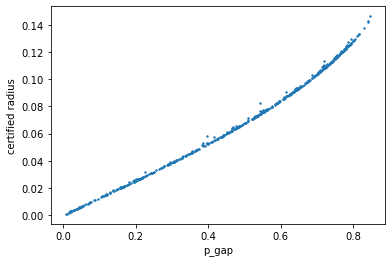

In [32]:
plt.scatter(eps_dependence[0], eps_dependence[2], s=2)
# plt.plot(np.linspace(0, 0.15, 100),np.linspace(0, 0.15, 100), linewidth=0.5)
plt.xlabel('p_gap')
plt.ylabel('certified radius')
plt.savefig('graphics/p_gap vs certified_radius.png',  transparent=False, facecolor='white', dpi=1000)

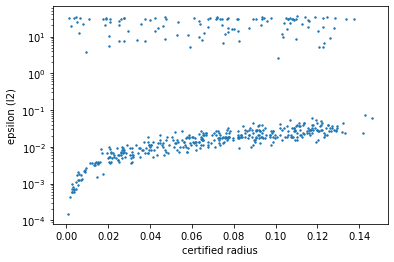

In [30]:
plt.scatter(eps_dependence[2], [el.item() for el in eps_dependence[3]], s=2)
# plt.plot(np.linspace(0, 0.15, 100),np.linspace(0, 0.15, 100), linewidth=0.5)
plt.xlabel('certified radius')
plt.ylabel('epsilon (l2)')
plt.yscale('log')
plt.savefig('graphics/epsilon(l2) vs certified_radius.png', transparent=False, facecolor='white', dpi=1000)